In [945]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')
print(df.shape)
df.head(5)

(1112, 13)


,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr
0,1,50002,1,50002,PITT,no_filename,1,10.201539,1.194664,16.223458,3.878000,0.152711,12.072452
1,2,50003,2,50003,PITT,Pitt_0050003,1,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155
2,3,50004,3,50004,PITT,Pitt_0050004,1,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463
3,4,50005,4,50005,PITT,Pitt_0050005,1,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200
4,5,50006,5,50006,PITT,Pitt_0050006,1,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574


In [946]:
#Dropping empty columns
df['DX_GROUP'].replace(2, 0, inplace=True) #So sigmoid function gives right output. if you replace sigmoid, you can skip this

df['anat_cnr'].replace('', np.nan, inplace=True)
df['anat_efc'].replace('', np.nan, inplace=True)
df['anat_fber'].replace('', np.nan, inplace=True)
df['anat_fwhm'].replace('', np.nan, inplace=True)
df['anat_qi1'].replace('', np.nan, inplace=True)
df['anat_snr'].replace('', np.nan, inplace=True)

#Replacing null values in all relevant input columns
df.dropna(subset=['anat_cnr','anat_efc', 'anat_fber', 'anat_fwhm', 'anat_qi1', 'anat_snr'], inplace=True)

#Verifying number of null rows
print("Number of null values:")
print(df.isnull().sum())

Number of null values:
Unnamed: 0    0
SUB_ID        0
X             0
subject       0
SITE_ID       0
FILE_ID       0
DX_GROUP      0
anat_cnr      0
anat_efc      0
anat_fber     0
anat_fwhm     0
anat_qi1      0
anat_snr      0
dtype: int64


In [947]:
X=df[['anat_cnr','anat_efc', 'anat_fber', 'anat_fwhm', 'anat_qi1', 'anat_snr']]
y=df['DX_GROUP']

train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
print("\nTraining data samples:")
print(train_x.shape)


Training data samples:
(824, 6)


In [948]:
from sklearn import preprocessing
import torch

#MinMaxscaler is used to scale all the features of Train & Test dataframes
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(train_x.values)
x_test =  scaler.fit_transform(test_x.values)

print("Scaled values of Train set \n")
print(x_train)
print("\nScaled values of Test set \n")
print(x_test)

#Train and Test sets are converted into Tensors
x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(train_y.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)

Scaled values of Train set 

[[2.66258512e-01 8.70834515e-01 5.95773557e-02 2.54271309e-01
  1.26426844e-01 3.48438215e-03]
 [2.95043381e-01 8.70250262e-01 6.07201068e-02 1.92902434e-01
  1.84607580e-01 2.87736912e-03]
 [2.21616507e-01 8.72967726e-01 1.99478635e-02 2.96678901e-01
  2.40373774e-01 2.92762111e-03]
 ...
 [8.61828200e-02 6.96365784e-01 1.05786600e-01 4.53536588e-01
  2.43836071e-01 1.95344244e-01]
 [5.72027934e-02 8.71470631e-01 6.19210410e-03 2.11209629e-01
  4.03582689e-01 7.57881642e-04]
 [1.90426202e-01 9.26341194e-01 1.81483671e-03 6.57822767e-02
  9.33983754e-01 1.53730773e-03]]

Scaled values of Test set 

[[0.32057977 0.70368126 0.09093268 0.34956924 0.19662656 0.00928808]
 [0.1501252  0.29007592 0.37771861 0.44484029 0.42582975 0.81990578]
 [0.78950843 0.70594588 0.70125689 0.70093313 0.17442246 0.03957116]
 ...
 [0.486924   0.73549778 0.03119208 0.28398418 0.15877921 0.02604569]
 [0.26211649 0.72729547 0.00411507 0.74963734 0.257693   0.01229725]
 [0.22294218 0.7

In [949]:
from torch.utils.data import TensorDataset, DataLoader

#Define batch size 
bs = 64
#x_train and y_train are combined to a single TensorDataset (easier to iterate over and slice)
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#DataLoader is responsible for managing batches, & makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)

#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [950]:
from torch import nn

n_input_dim = train_x.shape[1]
#Layer size
n_hidden1 = 3  # Number of hidden nodes
n_hidden2 = 2
n_output =  1   # Number of output nodes for binary classifier

class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() #outputs probability between 0 and 1
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=6, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=2, bias=True)
  (layer_out): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [951]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay= 1e-6)
epochs = 100

In [952]:
model.train()
train_loss, valid_loss = [], []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    train_loss.append(loss.item())
    # evaluation part 
    model.eval()
    for xb, yb in test_loader:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)
        valid_loss.append(loss.item())
print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))

Epoch: 99 Training Loss:  0.6907291102409363 Valid Loss:  0.6915017668406168


In [953]:
import itertools

y_pred_list = []
model.eval()
#Model doesn't need to backpropagate the gradients in test set, so use torch.no_grad()
#reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

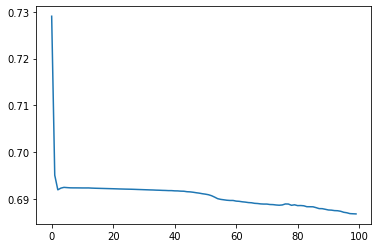

In [954]:
plt.plot(train_loss)
plt.show()

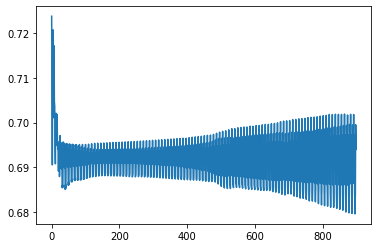

In [955]:
plt.plot(valid_loss)
plt.show()

In [956]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

#Classification accuracy
y_true_test = test_y.values.ravel()
print(metrics.classification_report(y_true_test,ytest_pred))

print("Precision Score : ",precision_score(y_true_test,ytest_pred, pos_label='positive', average=None))
print("Recall Score : ",recall_score(y_true_test,ytest_pred, pos_label='positive', average=None))
print("F1 Score : ",f1_score(y_true_test,ytest_pred, pos_label='positive', average=None))

              precision    recall  f1-score   support

           0       0.58      0.82      0.68       152
           1       0.53      0.25      0.34       123

    accuracy                           0.57       275
   macro avg       0.56      0.54      0.51       275
weighted avg       0.56      0.57      0.53       275

Precision Score :  [0.57603687 0.53448276]
Recall Score :  [0.82236842 0.25203252]
F1 Score :  [0.67750678 0.34254144]


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
